In [2]:
import jax.numpy as jnp
import jax
from jax import vmap, jit
import optax
from functools import partial
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')

from KANWrapper import SF_KAN

# Create interior points
L_range = (0.0, 1.0)
H_range = (0.0, 1.0)
nx, ny = 100, 100
x = np.linspace(L_range[0], L_range[1], nx)
y = np.linspace(H_range[0], H_range[1], ny)
X, Y = np.meshgrid(x, y)
xy_domain = np.column_stack((X.ravel(), Y.ravel()))

# Create boundary points
x_boundary = np.concatenate([np.full(ny, L_range[0]), np.full(ny, L_range[1]), x, x])
y_boundary = np.concatenate([y, y, np.full(nx, H_range[0]), np.full(nx, H_range[1])])
xy_boundary = np.column_stack((x_boundary, y_boundary))


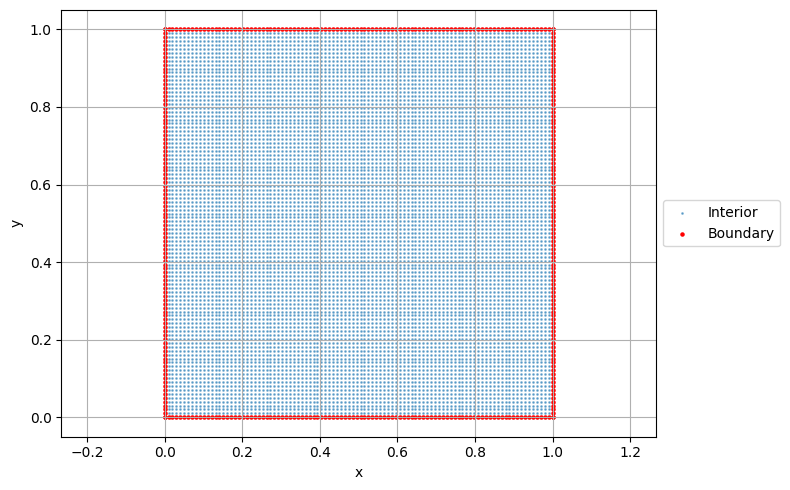

In [3]:
def plot_domain_setup(xy_domain, xy_boundary):
    plt.figure(figsize=(8, 5))
    
    # Plot interior points
    plt.scatter(xy_domain[:, 0], xy_domain[:, 1], s=1, alpha=0.5, label='Interior')
    
    # Plot boundary points
    plt.scatter(xy_boundary[:, 0], xy_boundary[:, 1], s=5, c='r', label='Boundary')
    
    plt.xlabel('x')
    plt.ylabel('y')
    # plt.title('Domain Setup for 2D Cavity Flow')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plot_domain_setup(xy_domain, xy_boundary)


In [4]:
class Cavity_SF_KAN(SF_KAN):
    def __init__(self, *args, Re=100.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.Re = Re

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, params, state, xy_domain, xy_boundary):
        variables = {'params': params, 'state': state}
        
        # Compute predictions and regularization for all points at once
        all_points = jnp.vstack([xy_domain, xy_boundary])
        preds, spl_regs = self.forward_pass(variables, all_points)
        
        # Split predictions for domain and boundary
        n_domain = xy_domain.shape[0]
        preds_domain = preds[:n_domain]
        preds_boundary = preds[n_domain:]
        
        # Physics loss (Navier-Stokes equations)
        def ns_residual(pred, x, y):
            u, v, p = pred
            
            # Compute all gradients at once
            grads = jax.jacrev(lambda inp: self.forward_pass(variables, inp.reshape(1, -1))[0].squeeze())(jnp.array([x, y]))
            du_dx, du_dy = grads[0]
            dv_dx, dv_dy = grads[1]
            dp_dx, dp_dy = grads[2]
            
            # Compute second derivatives
            d2u_dx2 = jax.jacfwd(lambda x: jax.jacfwd(lambda x: self.forward_pass(variables, jnp.array([[x, y]]))[0][0, 0])(x))(x)
            d2u_dy2 = jax.jacfwd(lambda y: jax.jacfwd(lambda y: self.forward_pass(variables, jnp.array([[x, y]]))[0][0, 0])(y))(y)
            d2v_dx2 = jax.jacfwd(lambda x: jax.jacfwd(lambda x: self.forward_pass(variables, jnp.array([[x, y]]))[0][0, 1])(x))(x)
            d2v_dy2 = jax.jacfwd(lambda y: jax.jacfwd(lambda y: self.forward_pass(variables, jnp.array([[x, y]]))[0][0, 1])(y))(y)
            
            continuity = du_dx + dv_dy
            momentum_x = u * du_dx + v * du_dy + dp_dx - (1./self.Re)*(d2u_dx2 + d2u_dy2)
            momentum_y = u * dv_dx + v * dv_dy + dp_dy - (1./self.Re)*(d2v_dx2 + d2v_dy2)
            return jnp.array([continuity, momentum_x, momentum_y])

        residuals = vmap(ns_residual)(preds_domain, xy_domain[:, 0], xy_domain[:, 1])
        physics_loss = jnp.mean(residuals**2)

        # Boundary loss
        def boundary_loss_fn(pred, x, y):
            u, v, _ = pred
            L = 1.

            left_wall_loss = jnp.where(x == 0, u**2 + v**2, 0)
            right_wall_loss = jnp.where(x == L, u**2 + v**2, 0)
            bottom_wall_loss = jnp.where(y == 0, u**2 + v**2, 0)
            top_wall_loss = jnp.where(y == L, (u - 1.)**2 + v**2, 0)
            
            return left_wall_loss + right_wall_loss + bottom_wall_loss + top_wall_loss

        boundary_losses = vmap(boundary_loss_fn)(preds_boundary, xy_boundary[:, 0], xy_boundary[:, 1])
        boundary_loss = jnp.mean(boundary_losses)

        # Regularization loss
        flattened_spl_reg = [jnp.ravel(arr) for arr in spl_regs]
        reg_loss = jnp.sum(jnp.concatenate(flattened_spl_reg))
        
        # Total loss
        total_loss = physics_loss + boundary_loss #+ 0.1*reg_loss
        return total_loss

In [ ]:
# Model parameters
layer_dims = [2, 9, 9, 3]  # Input dim is 2 (x, y), output dim is 3 (u, v, p)
init_lr = 1e-3
Re = 100.0  # Reynolds number

model = Cavity_SF_KAN(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k=3,
    Re=Re,
)

# Train the model
num_epochs = 900000
final_variables, loss_history = model.train(num_epochs=num_epochs, xy_domain=xy_domain, xy_boundary=xy_boundary)


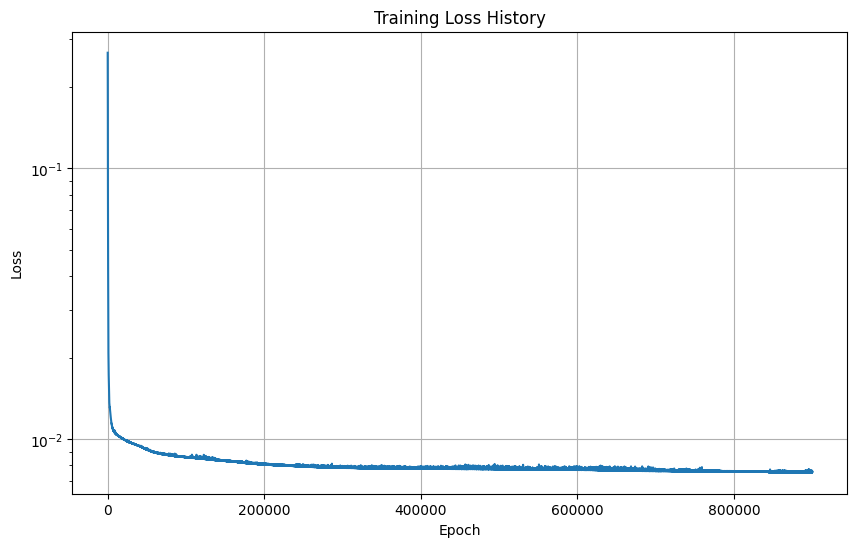

In [14]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.title('Training Loss History')
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)

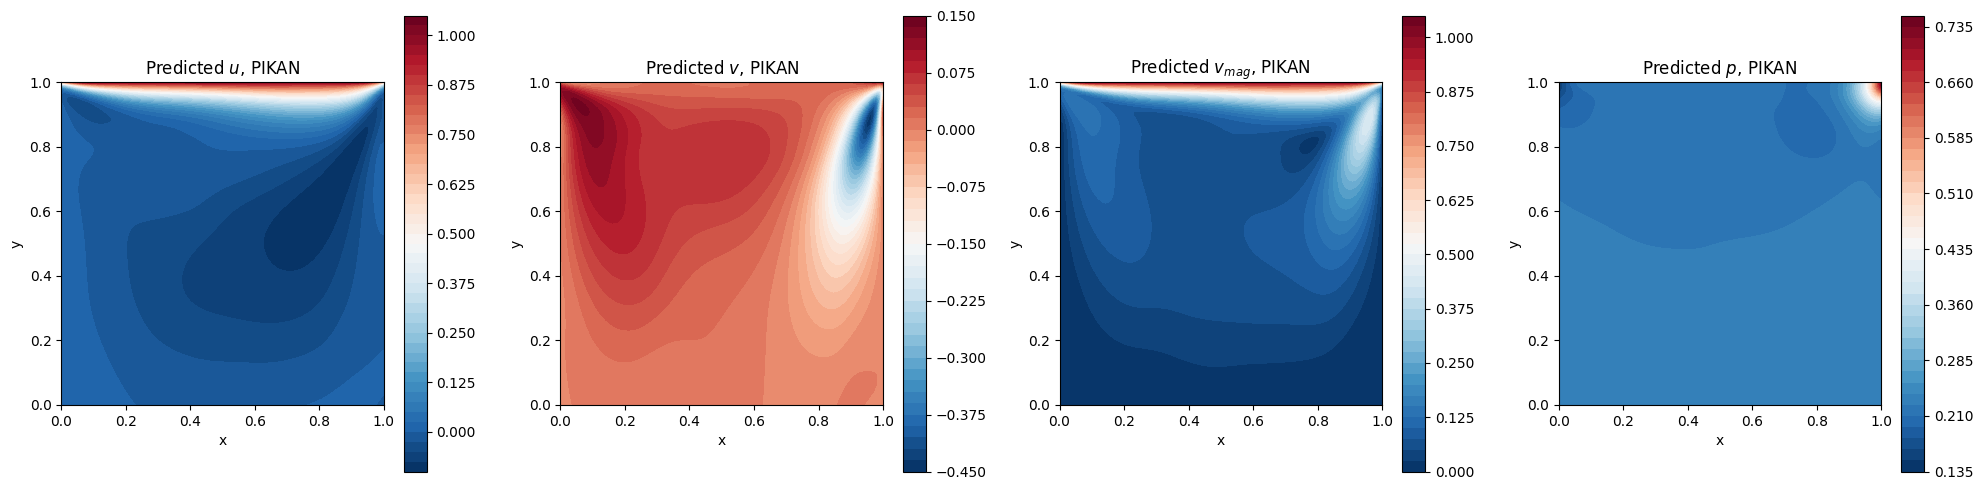

In [15]:
# Generate solution
nx_plot, ny_plot = 100, 100
x_plot = jnp.linspace(L_range[0], L_range[1], nx_plot)
y_plot = jnp.linspace(L_range[0], L_range[1], ny_plot)
X_mesh, Y_mesh = jnp.meshgrid(x_plot, y_plot)
xy_plot = jnp.column_stack((X_mesh.ravel(), Y_mesh.ravel()))

# Make predictions
fields_pred, _ = model.forward_pass({'params': final_variables['params'], 'state': final_variables['state']}, xy_plot)
uvp_pred = fields_pred.reshape(nx_plot * ny_plot, 3)
uvp_pred = uvp_pred.reshape(nx_plot, ny_plot, 3)

# Extract u, v, p
U = np.array(uvp_pred[:, :, 0])
V = np.array(uvp_pred[:, :, 1])
P = np.array(uvp_pred[:, :, 2])

vmag = np.sqrt(U**2 + V**2)

# Plotting
fig1, axs1 = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns

im00 = axs1[0].contourf(X_mesh, Y_mesh, U, levels=50, cmap='RdBu_r')
axs1[0].set_title(r'Predicted $u$, PIKAN')
plt.colorbar(im00, ax=axs1[0])

im01 = axs1[1].contourf(X_mesh, Y_mesh, V, levels=50, cmap='RdBu_r')
axs1[1].set_title(r'Predicted $v$, PIKAN')
plt.colorbar(im01, ax=axs1[1])

im02 = axs1[2].contourf(X_mesh, Y_mesh, vmag, levels=50, cmap='RdBu_r')
axs1[2].set_title(r'Predicted $v_{mag}$, PIKAN')
plt.colorbar(im02, ax=axs1[2])

im03 = axs1[3].contourf(X_mesh, Y_mesh, P, levels=50, cmap='RdBu_r')
axs1[3].set_title(r'Predicted $p$, PIKAN')
plt.colorbar(im03, ax=axs1[3])

for ax in axs1:
    ax.set_aspect('equal')
    ax.set_xlim(L_range[0], L_range[1])
    ax.set_ylim(L_range[0], L_range[1])
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

In [ ]:
# Create dictionary with all field data


output_data = {
    'mesh': {
        'x_mesh': X_mesh,
        'y_mesh': Y_mesh,
        'L_range': L_range
    },
    'field_variables': {
        'u': U,
        'v': V,
        'vmag': vmag,  # velocity magnitude
        'p': P
    },
    'parameters': {
        'Re': Re
    },
    'training': {
        'loss_history': loss_history
    }
}

# Save data
np.save(f'./data/2d_ns_pikan_Re_{Re}_nx{nx}_ny{ny}_epochs{num_epochs}_{layer_dims}.npy', output_data)



In [ ]:
def count_trainable_params(params):
    flat_params, _ = jax.tree_util.tree_flatten(params)
    return sum(p.size for p in flat_params)

num_params = count_trainable_params(final_variables['params'])
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 1029
